In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

In [1]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program/Graphviz/bin/'
import pydot
import graphviz
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [33]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, data_dir='E:/mask')

Dataset oxford_iiit_pet downloaded and prepared to E:/mask\oxford_iiit_pet\3.2.0. Subsequent calls will reuse this data.


In [2]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [3]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

NameError: name 'info' is not defined

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefech(buffer_size = tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

In [ ]:
for image, mask in train.take(i):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

In [6]:
OUTPUT_CHANNELS = 3

In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu', 'block_13_expand_relu', 'block_16_project',]

layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [9]:
up_stack = [pix2pix.upsample(512,3), pix2pix.upsample(256,3), pix2pix.upsample(128,3), pix2pix.upsample(64,3)]

In [11]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128,128,3])
    x = inputs

    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        # down_stack과 up_stack을 연결
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same')

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## 모델 학습
- 손실 함수는 loss.sparse_categorical_crossentropy

    - 이 손실 함수를 사용하는 이유는 네트워크가 멀티 클래스 예측과 마찬가지로 픽셀마다 레이블을 할당하려고 하기 때문

    - 실제 분할 마스크에서 각 픽셀은 {0,1,2}를 가지고 있고, 이곳의 네트워크는 세 개의 채널을 출력

    - 기본적으로 각 채널은 클래스를 예측하는 방법을 배우려고 하고 있으며, loss.sparse_categical_crossentropy는 그러한 시나리오에 권장되는 손실

    - 네트워크의 출력을 사용하여 픽셀에 할당된 레이블은 가장 높은 값을 가진 채널임 이것이 create_mask 함수가 하는 일입니다.


In [12]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


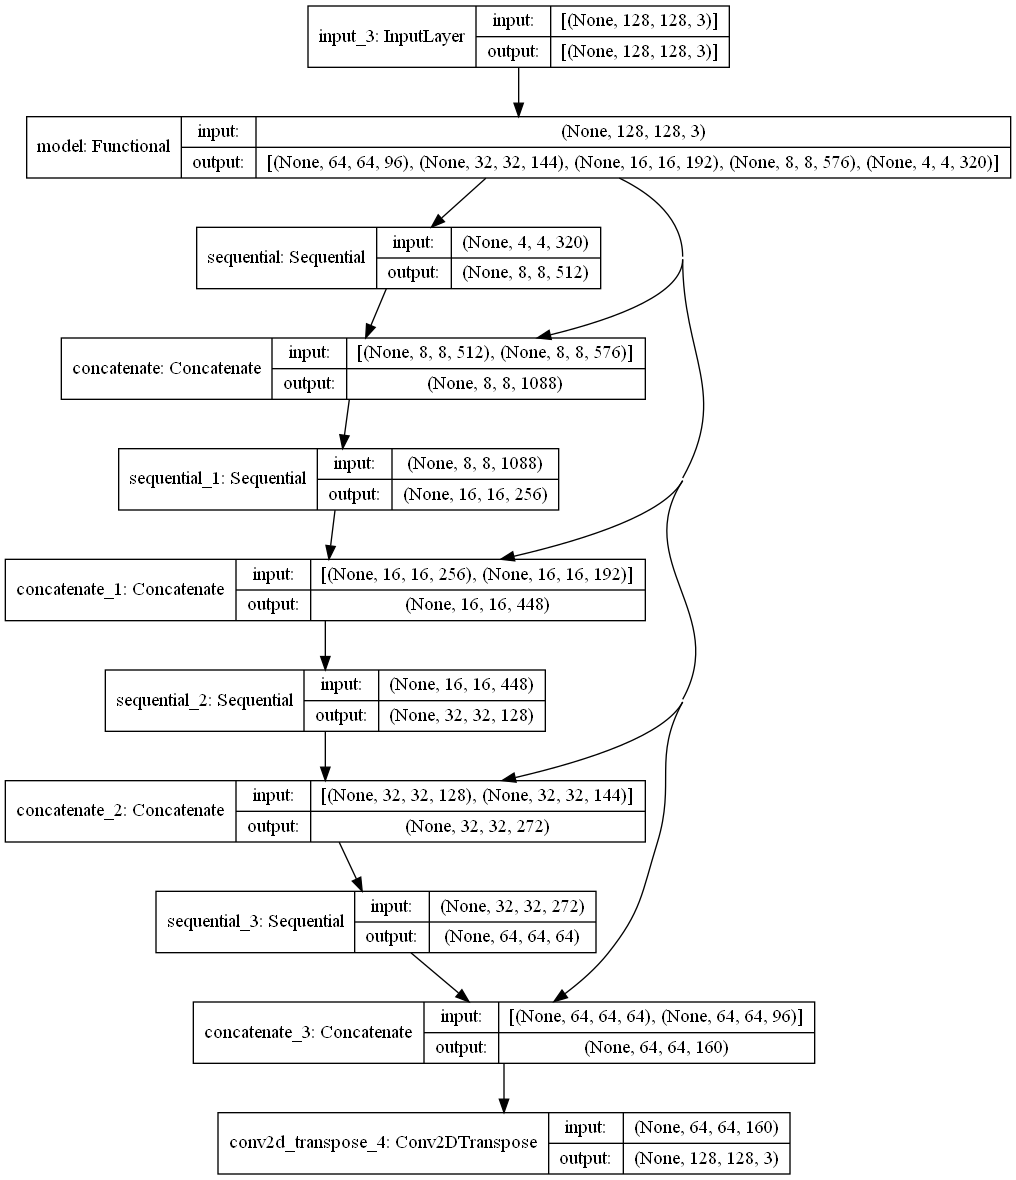

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    return pred_mask[0]

In [26]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display(image[0], mask[0], create_mask(pred_mask))
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [27]:
show_predictions()

NameError: name 'sample_image' is not defined

In [29]:
class DisplayCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('{} Epochs'.format(epoch+1))

In [31]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset, callbacks=[DisplayCallback()])

NameError: name 'info' is not defined

In [32]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r-', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b:', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'model_history' is not defined

In [ ]:
show_predictions(test_dataset, 5)